## Load the Dependencies

In [46]:
# Lets import resources

from tensorflow.keras.preprocessing.image import save_img
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Keras models
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image as keras_image
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras import backend

# Numpy is needed for dealing with large arrays
import numpy as np

# PIL Library is used to deal with images
from PIL import Image

# Optimizing 
from scipy.optimize import fmin_l_bfgs_b
from platform import python_version
import matplotlib.pyplot as plt
import matplotlib as mpl
import time

mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

## Define the Globals

In [48]:
# Hyperparams
image_size = 512 # Image size
epochs = 15 # Decide how many iterations to update image (15)
channels = 3

# These are the weights of the different loss components
content_weight = 0.02
style_weight = 4.5
total_variation_weight = 0.995
total_variation_loss_factor = 1.25

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
backend.set_session(tf.Session(config = config))

2022-01-17 00:08:54.286374: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-17 00:08:54.289239: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-17 00:08:54.289264: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-17 00:08:54.289296: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost.localdomain): /proc/driver/nvidia/version does not exist


## Define the content and style images

In [49]:
# This is the path to the image you want to transform.
content_path = 'joconde.jpeg'

# This is the path to the style image.
style_path = 'starry_night.jpg'

# This is the path to the result image.
saved_image_filename = 'joconde_night.jpg'

## Define the size of the generated images

In [47]:
# Dimensions of the generated picture
width, height = load_img(content_path).size
image = Image.open(content_path)
long = max(image.size)
scale = image_size / long
image_width = round(image.size[0] * scale)
image_height = round(image.size[1] * scale)
print(width)
print(height)

182
276


In [51]:
# Need to convert the images from 3D to 4 Dimensions
# Util function to open, resize and format pictures into appropriate tensors

def load_and_process_image(image_path):
    image = Image.open(image_path)
    image = image.resize((image_width, image_height), Image.ANTIALIAS)
    image = keras_image.img_to_array(image, dtype = 'float32')
    image = np.expand_dims(image, axis = 0)
    image[:, :, :, 0] -= 103.939
    image[:, :, :, 1] -= 116.779
    image[:, :, :, 2] -= 123.68
    image = image[:, :, :, ::-1]
    return image

In [50]:
# Util function to convert a tensor into a valid image
def deprocess_image(input_image):
    new_image = input_image.copy()
    new_image = new_image.reshape((image_height, image_width, channels))
    new_image = new_image[:, :, ::-1]
    # Remove zero-center by mean pixel
    new_image[:, :, 0] += 103.939
    new_image[:, :, 1] += 116.779
    new_image[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    new_image = np.clip(new_image, 0, 255).astype("uint8")
    return new_image

In [9]:
def display_image(image, title):
    image = deprocess_image(image)

    plt.figure(figsize = (10, 8))
    plt.title = title
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    return

## Turn the images into arrays

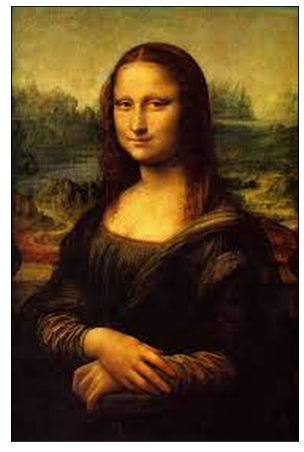

In [10]:
# Content image
content_image_array = load_and_process_image(content_path)
display_image(content_image_array, 'Content Image')

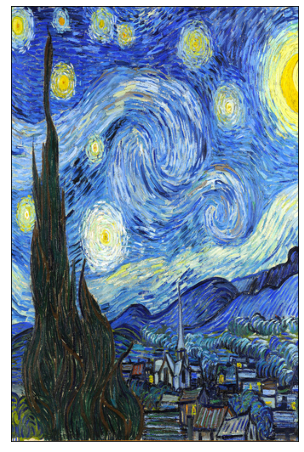

In [11]:
# Style image
style_image_array = load_and_process_image(style_path)
display_image(style_image_array, 'Style Image')

## Turn the arrays into tensors

In [52]:
# Get tensor representations of our images
content_image = backend.variable(content_image_array)
style_image = backend.variable(style_image_array)

# This placeholder will contain our generated image
generated_image = backend.placeholder((1, image_height, image_width, channels))

## Load the model

In [53]:
# We combine the 3 images into a single batch
input_tensor = backend.concatenate([content_image, style_image, generated_image], axis = 0)

# We build the VGG19 network with our batch of 3 images as input.
model = VGG19(input_tensor = input_tensor, include_top = False)

In [44]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(3, 512, 338, 3)]        0         
                                                                 
 block1_conv1 (Conv2D)       (3, 512, 338, 64)         1792      
                                                                 
 block1_conv2 (Conv2D)       (3, 512, 338, 64)         36928     
                                                                 
 block1_pool (MaxPooling2D)  (3, 256, 169, 64)         0         
                                                                 
 block2_conv1 (Conv2D)       (3, 256, 169, 128)        73856     
                                                                 
 block2_conv2 (Conv2D)       (3, 256, 169, 128)        147584    
                                                                 
 block2_pool (MaxPooling2D)  (3, 128, 84, 128)         0     

# Define the content layer and style layers to be used

In [54]:
# Extracting the layers of CONTENT from the above layers mostly from the front layers in the architecture because according to the paper 
# Content layer where will pull our feature maps
content_layer = 'block2_conv2'
# Computing Loss over 5 different layers to find the style loss
style_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
layers = dict([(layer.name, layer.output) for layer in model.layers])

In [15]:
# Splitting layer data into content and output image
layer_features = layers[content_layer]
content_features = layer_features[0, :, :, :]
generated_features = layer_features[2, :, :, :]

## Define the content loss, style loss, and total variation loss

**Content Loss**

We will actually add our content losses at each desired layer.

This way, each iteration when we feed our input image through the model all the content losses through the model will be properly compute and because we are executing eagerly, all the gradients will be computed.

In [16]:
# We need to define a function i.e content loss which is computing the loss between output image and content image
def content_loss(content, generated):
    return backend.sum(backend.square(generated - content))

**Style Loss**

In [17]:
# Computing the gram matrix 
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [18]:
# Style Loss function generally computes the loss between 2 gram matrices of the layers output for the style and combination images 
def compute_style_loss(style, generated):
    S = gram_matrix(style)
    G = gram_matrix(generated)
    size = image_height * image_width
    return backend.sum(backend.square(S - G)) / (4. * (channels ** 2) * (size ** 2))

In [19]:
# Adding the variation Loss makes the image noise free and smooth
def total_variation_loss(some_image):
    a = backend.square(some_image[:, :image_height - 1, :image_width - 1, :] - some_image[:, 1:, :image_width - 1, :])
    b = backend.square(some_image[:, :image_height - 1, :image_width - 1, :] - some_image[:, :image_height - 1, 1:, :])
    return backend.sum(backend.pow(a + b, total_variation_loss_factor))

## Calculate the total loss

In [26]:
# Adding the variation Loss makes the image noise free and smooth
loss = backend.variable(0.)
loss = loss + content_weight * content_loss(content_features, generated_features)

for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (style_weight / len(style_layers)) * style_loss

loss += total_variation_weight * total_variation_loss(generated_image)    

In [27]:
# This function is used to make optimizer function work because here we use fmin_l_bfgs_b which optimizes the argument ehich is in the function 
class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

In [28]:
# Obtaining the loss and gradients  
def evaluate_loss_and_gradients(some_image):
    some_image = some_image.reshape((1, image_height, image_width, channels))
    outs = backend.function([generated_image], outputs)([some_image])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

In [29]:
# Adding the loss with gradients with respect to combination_image
# Compute gradients wrt input image
outputs = [loss]
outputs += backend.gradients(loss, generated_image)

## Begin the NST loop, minimizing loss and gradients

We’ll run 15 iterations, where each iteration consists of 10 steps of gradient descent. We also save the generated image at each iteration so we can track our progress.

In [55]:
# Initialising a random image
# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
def neural_style_transfer():
    evaluator = Evaluator()
    progress = np.random.uniform(0, 255, (1, image_height, image_width, channels)) - 128.
    start_time = time.time()
    for lp in range(epochs):
        progress, loss, info = fmin_l_bfgs_b(evaluator.loss, progress.flatten(), fprime = evaluator.gradients, maxfun = 20)
        print("Epoch(%d)  Loss = %d, Time = %d seconds" % (lp + 1, loss, round((time.time() - start_time),2)))
    return progress

In [31]:
generated_image = neural_style_transfer()

2022-01-17 00:10:46.564887: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 398721024 exceeds 10% of free system memory.
2022-01-17 00:10:56.691581: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 398721024 exceeds 10% of free system memory.
2022-01-17 00:11:07.166056: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 398721024 exceeds 10% of free system memory.
2022-01-17 00:11:17.809514: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 398721024 exceeds 10% of free system memory.
2022-01-17 00:11:28.496619: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 398721024 exceeds 10% of free system memory.


Epoch(1)  Loss = 45203664896, Time = 237 seconds
Epoch(2)  Loss = 25010905088, Time = 492 seconds
Epoch(3)  Loss = 18852982784, Time = 752 seconds
Epoch(4)  Loss = 15201386496, Time = 1001 seconds
Epoch(5)  Loss = 13479831552, Time = 1252 seconds
Epoch(6)  Loss = 12476637184, Time = 1502 seconds
Epoch(7)  Loss = 11733579776, Time = 1752 seconds
Epoch(8)  Loss = 11251681280, Time = 2002 seconds
Epoch(9)  Loss = 10866669568, Time = 2254 seconds
Epoch(10)  Loss = 10613539840, Time = 2506 seconds
Epoch(11)  Loss = 10403835904, Time = 2760 seconds
Epoch(12)  Loss = 10179977216, Time = 3013 seconds
Epoch(13)  Loss = 10020422656, Time = 3266 seconds
Epoch(14)  Loss = 9905873920, Time = 3519 seconds
Epoch(15)  Loss = 9778134016, Time = 3775 seconds


In [32]:
generated_image = deprocess_image(generated_image)
generated_image = keras_image.array_to_img(generated_image)

In [56]:
def imshow(image):
    # Remove the batch dimension
    image = np.squeeze(image, axis = 0)
    image[:, :, 0] += 103.939
    image[:, :, 1] += 116.779
    image[:, :, 2] += 123.68
    image = image[:, :, ::-1]
    # Normalize for display 
    image = np.clip(image, 0, 255).astype('uint8')
    plt.imshow(image)

## Display and save the final results

In [57]:
def show_final_results(content, style, generated):
    # Content image
    plt.figure(figsize = (10, 5))
    plt.subplot(1, 2, 1)
    imshow(content)
    plt.subplot(1, 2, 2)
    # Style image
    imshow(style)
    # plt.figure()
    plt.figure(figsize = (10, 10))
    # Generate image
    plt.imshow(generated)
    plt.show()

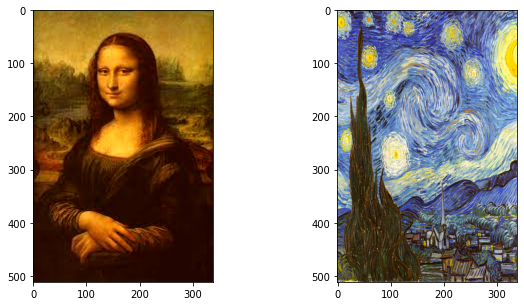

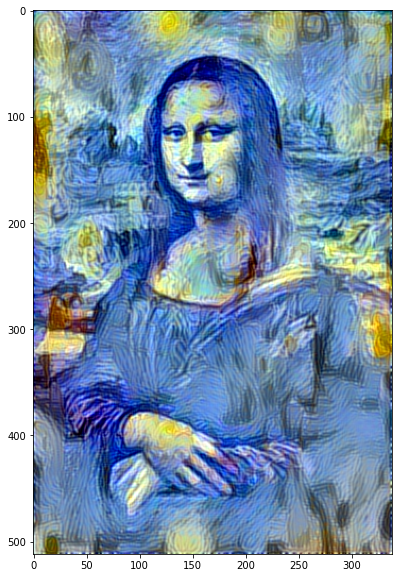

In [38]:
show_final_results(load_and_process_image(content_path), load_and_process_image(style_path), generated_image)

In [ ]:
# Save the generated_image
save_img(saved_image_filename, generated_image)